# Model Comparison in PyMC

This notebook demonstrates Bayesian model comparison techniques using PyMC and ArviZ. We'll implement the classic **8 schools example** from Section 5.5 of Gelman et al (2003), which infers the effects of coaching on SAT scores across 8 schools.

## Overview

We'll compare two models:
1. **Pooled Model**: Assumes a single fixed effect across all schools
2. **Hierarchical Model**: Allows for random effects with partial pooling

We'll use two main information criteria for model comparison:
- **LOO (Leave-One-Out Cross-Validation)**: Estimates out-of-sample predictive fit using Pareto-smoothed importance sampling
- **WAIC (Widely Applicable Information Criterion)**: A fully Bayesian criterion using log pointwise posterior predictive density

**References:**
- Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models
- Vehtari, A., Gelman, A., Gabry, J. (2016). Practical Bayesian model evaluation using LOO cross-validation and WAIC

In [2]:
import arviz as az
import numpy as np

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


## Setup and Data

First, we'll import the necessary libraries and load the 8 schools dataset. The data includes:
- `y`: Observed treatment effects (coaching effects on SAT scores) for each school
- `sigma`: Standard deviations associated with each observation
- `J`: Number of schools (8)

In [3]:
az.style.use("arviz-darkgrid")

In [4]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

## Model 1: Pooled Model

The pooled model assumes **complete pooling** - a single fixed coaching effect applies to all schools. This is the simplest model that ignores between-school variation.

**Model specification:**
- Prior: $\mu \sim \text{Normal}(0, 10^6)$ (weakly informative prior on the pooled effect)
- Likelihood: $y_j \sim \text{Normal}(\mu, \sigma_j)$ for each school $j$

This model assumes all schools share the same underlying true effect $\mu$.

In [5]:
with pm.Model() as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


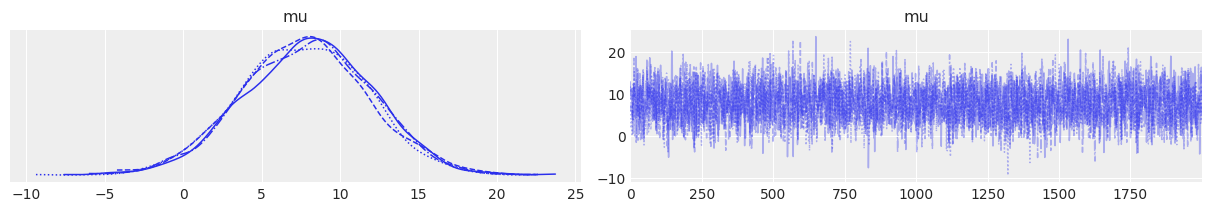

In [6]:
az.plot_trace(trace_p);

### Trace Plot for Pooled Model

The trace plot shows the posterior distribution and MCMC sampling behavior for the pooled effect parameter $\mu$.

## Model 2: Hierarchical Model

The hierarchical model uses **partial pooling** - each school has its own effect $\theta_j$, but these effects are drawn from a common distribution. This allows information to be shared across schools while maintaining individual variation.

**Model specification:**
- Hyperpriors: 
  - $\mu \sim \text{Normal}(0, 10)$ (population mean effect)
  - $\tau \sim \text{HalfNormal}(10)$ (between-school standard deviation)
- School-specific effects: $\eta_j \sim \text{Normal}(0, 1)$
- Non-centered parameterization: $\theta_j = \mu + \tau \cdot \eta_j$
- Likelihood: $y_j \sim \text{Normal}(\theta_j, \sigma_j)$

**Why non-centered parameterization?**
The non-centered form ($\theta = \mu + \tau \cdot \eta$) improves MCMC sampling efficiency, especially when $\tau$ is small, by reducing correlation between parameters.

In [7]:
with pm.Model() as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

    trace_h = pm.sample(2000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


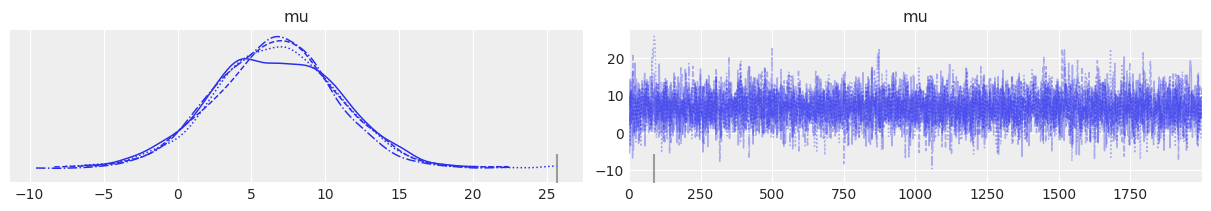

In [8]:
az.plot_trace(trace_h, var_names="mu");

### Posterior Visualization for Hierarchical Model

The trace plot shows the posterior for the population mean $\mu$, and the forest plot displays the school-specific effects $\theta_j$ with their uncertainty intervals.

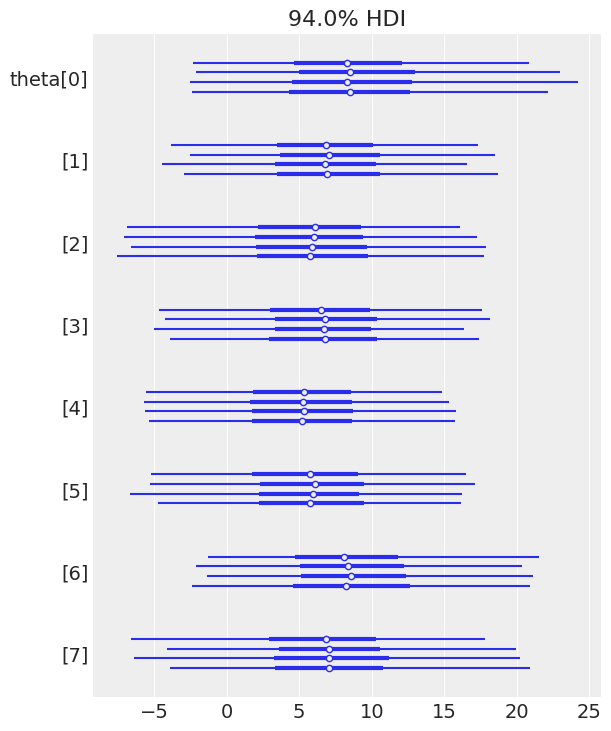

In [9]:
az.plot_forest(trace_h, var_names="theta");

## Model Comparison: Computing Information Criteria

To compare models, we need to compute the log-likelihood for each observation. ArviZ uses this to calculate information criteria.

### What are LOO and WAIC?

**Leave-One-Out Cross-Validation (LOO):**
- Estimates out-of-sample predictive performance
- Uses Pareto-smoothed importance sampling (PSIS) to efficiently compute LOO from MCMC samples
- No need to refit the model multiple times
- Introduced by Vehtari et al. (2016)

**Widely Applicable Information Criterion (WAIC):**
- Fully Bayesian alternative to AIC
- Computes log pointwise posterior predictive density (LPPD)
- Corrects for effective number of parameters to adjust for overfitting
- Introduced by Watanabe (2010)

**Key metrics returned:**
- `elpd_loo`: Expected log pointwise predictive density (higher is better)
- `p_loo`: Effective number of parameters (penalty term)
- **Pareto k diagnostic**: Indicates reliability of LOO computation
  - k < 0.5: Good
  - 0.5 < k < 0.7: OK
  - k > 0.7: Bad (LOO may be unreliable)

In [10]:
with pooled:
    pm.compute_log_likelihood(trace_p)

Output()

In [11]:
pooled_loo = az.loo(trace_p)

pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.57     1.10
p_loo        0.68        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### LOO Results for Pooled Model

The output shows:
- `elpd_loo`: Expected log predictive density
- `p_loo`: Effective number of parameters (~0.69, close to 1 as expected for a single parameter model)
- Pareto k diagnostics: All values in "good" range indicate reliable LOO estimates

In [12]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

Output()

In [13]:
hierarchical_loo = az.loo(trace_h)

hierarchical_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.84     1.06
p_loo        1.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### LOO Results for Hierarchical Model

Notice that:
- `p_loo` is higher (~1.17) reflecting the additional complexity from the hierarchical structure
- Some Pareto k values are in the "OK" range (0.5-0.7), suggesting slightly less stable estimates
- This is common for hierarchical models with limited data

In [14]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.565023,0.679107,0.000000,1.0,1.097717,0.000000,False,log
hierarchical,1,-30.838129,1.184298,0.273106,0.0,1.062264,0.226052,False,log


## Direct Model Comparison with `az.compare()`

The `az.compare()` function provides a comprehensive comparison table. Let's understand each column:

### Column Interpretation:

1. **rank**: Model ranking (0 = best model)
2. **loo**: LOO values (higher is better in log scale)
3. **p_loo**: Effective number of parameters (penalization term)
4. **d_loo**: Difference from the best model (always 0 for top-ranked model)
5. **weight**: Model weights - loosely interpreted as the probability each model is "true" given the data
6. **se**: Standard error of LOO computation
7. **dse**: Standard error of the difference between models
   - Important: Accounts for correlation between model uncertainties
   - Different from simply comparing individual SEs
8. **warning**: Flags if LOO/WAIC computation may be unreliable
9. **loo_scale**: Reporting scale (default is log; other options: deviance, negative-log)

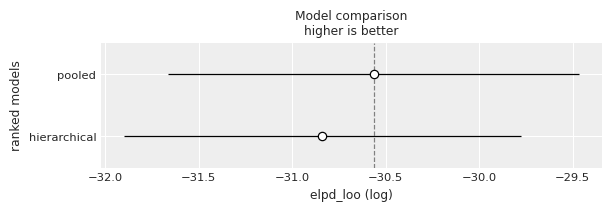

In [15]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Visual Model Comparison

The `az.plot_compare()` function creates a summary plot inspired by Richard McElreath's *Statistical Rethinking*.

**Reading the plot:**
- **Empty circles**: LOO values for each model
- **Black error bars**: Standard deviation of LOO
- **Vertical dashed line**: Best model's LOO value (reference point)
- **Triangles**: Difference in LOO from the best model
- **Grey error bars on triangles**: Standard error of the difference (accounts for correlation)

In [ ]:
## Additional Analysis: WAIC Comparison

Let's also compute WAIC as an alternative to LOO:

In [ ]:
# Compute WAIC for both models
pooled_waic = az.waic(trace_p)
hierarchical_waic = az.waic(trace_h)

print("Pooled Model WAIC:")
print(pooled_waic)
print("\nHierarchical Model WAIC:")
print(hierarchical_waic)

In [ ]:
# Compare using WAIC instead of LOO
df_comp_waic = az.compare({"hierarchical": trace_h, "pooled": trace_p}, ic="waic")
df_comp_waic

### Understanding Model Weights

The `weight` column in the comparison table represents **stacking weights** - these can be loosely interpreted as the probability that each model is the "true" model given the data. Let's examine these weights more closely:

In [ ]:
# Extract and visualize model weights
import matplotlib.pyplot as plt

weights = df_comp_loo['weight'].values
models = df_comp_loo.index.values

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(models, weights)
ax.set_xlabel('Model Weight', fontsize=12)
ax.set_title('Stacking Weights for Model Comparison', fontsize=14)
ax.set_xlim(0, 1)
for i, (model, weight) in enumerate(zip(models, weights)):
    ax.text(weight + 0.02, i, f'{weight:.3f}', va='center', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"The pooled model has a weight of {weights[0]:.3f}, suggesting")
print(f"it is favored with approximately {weights[0]*100:.1f}% confidence.")
print(f"The hierarchical model has a weight of {weights[1]:.3f} ({weights[1]*100:.1f}%).")

## Interpretation and Conclusions

### Model Comparison Results

Though we might expect the hierarchical model to significantly outperform the pooled model (given its ability to capture between-school variation), **there is little to distinguish between the models in this case**.

**Key observations:**
1. Both models have very similar LOO values (difference ~0.24)
2. The standard error of the difference (`dse`) indicates substantial uncertainty
3. When accounting for uncertainty, the models are essentially equivalent for this dataset

### Why are the models so similar?

This equivalence suggests:
- The data may not provide strong evidence for substantial between-school variation
- With only 8 schools and noisy measurements, there's insufficient information to reliably estimate hierarchical structure
- The pooled model's simplicity is not being penalized much because it fits nearly as well

### Practical Implications

1. **Model selection**: When models are this close, consider:
   - Theoretical justification (hierarchical structure is more realistic)
   - Computational cost (pooled is simpler)
   - Interpretability needs (hierarchical provides school-specific estimates)

2. **Uncertainty matters**: Always consider standard errors, not just point estimates of LOO/WAIC

3. **Domain knowledge**: The hierarchical model may still be preferred based on subject-matter considerations, even if not strongly favored by information criteria

### Best Practices for Model Comparison

- ✅ Check Pareto k diagnostics (values > 0.7 indicate problems)
- ✅ Report both point estimates and uncertainty (SE, dSE)
- ✅ Consider multiple criteria (LOO, WAIC, posterior predictive checks)
- ✅ Use domain knowledge alongside statistical metrics
- ✅ Visualize comparisons with `az.plot_compare()`
- ✅ Examine model weights for relative support

### When to use LOO vs WAIC?

Both are valid, but:
- **LOO** is generally preferred (ArviZ default) because:
  - Provides Pareto k diagnostics for reliability checking
  - More robust in edge cases
  - Better theoretical properties
  
- **WAIC** may be used when:
  - You want a fully Bayesian alternative to AIC
  - Historical comparison to older literature
  - Computational constraints (slightly faster)

### References

- Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. *Statistics and Computing*, 24(6), 997–1016.
- Vehtari, A., Gelman, A., Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. *Statistics and Computing*, 27(5), 1413-1432.
- Watanabe, S. (2010). Asymptotic equivalence of Bayes cross validation and widely applicable information criterion in singular learning theory. *Journal of Machine Learning Research*, 11, 3571-3594.
- McElreath, R. (2020). *Statistical Rethinking: A Bayesian Course with Examples in R and Stan* (2nd ed.). CRC Press.

## Interpretation and Conclusions

### Model Comparison Results

Though we might expect the hierarchical model to significantly outperform the pooled model (given its ability to capture between-school variation), **there is little to distinguish between the models in this case**.

**Key observations:**
1. Both models have very similar LOO values (difference ~0.24)
2. The standard error of the difference (`dse`) indicates substantial uncertainty
3. When accounting for uncertainty, the models are essentially equivalent for this dataset

### Why are the models so similar?

This equivalence suggests:
- The data may not provide strong evidence for substantial between-school variation
- With only 8 schools and noisy measurements, there's insufficient information to reliably estimate hierarchical structure
- The pooled model's simplicity is not being penalized much because it fits nearly as well

### Practical Implications

1. **Model selection**: When models are this close, consider:
   - Theoretical justification (hierarchical structure is more realistic)
   - Computational cost (pooled is simpler)
   - Interpretability needs (hierarchical provides school-specific estimates)

2. **Uncertainty matters**: Always consider standard errors, not just point estimates of LOO/WAIC

3. **Domain knowledge**: The hierarchical model may still be preferred based on subject-matter considerations, even if not strongly favored by information criteria

### Best Practices for Model Comparison

- ✅ Check Pareto k diagnostics (values > 0.7 indicate problems)
- ✅ Report both point estimates and uncertainty (SE, dSE)
- ✅ Consider multiple criteria (LOO, WAIC, posterior predictive checks)
- ✅ Use domain knowledge alongside statistical metrics
- ✅ Visualize comparisons with `az.plot_compare()`

### References

- Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. *Statistics and Computing*, 24(6), 997–1016.
- Vehtari, A., Gelman, A., Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. *Statistics and Computing*, 27(5), 1413-1432.
- Watanabe, S. (2010). Asymptotic equivalence of Bayes cross validation and widely applicable information criterion in singular learning theory. *Journal of Machine Learning Research*, 11, 3571-3594.